# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Training base models

In [5]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [6]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [7]:
lgbm_params = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "colsample_bytree": 0.5,
    "n_estimators": 5000,
    "max_depth": 7,
    "n_jobs": -1,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "device": "gpu",
    "max_depth": 7,
    "colsample_bytree": 0.5,
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbose": -1
}


xgb_params = {
    # https://www.kaggle.com/code/ravi20076/playgrounds5e6-public-baseline-v1
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "device": "gpu",
    "learning_rate": 0.03,
    "n_estimators": 10_000,
    "max_depth": 7,
    "subsample": 0.80,
    "colsample_bytree": 0.60,
    "colsample_bynode": 0.65,
    "colsample_bylevel": 0.825,
    "verbosity": 0,
    "random_state": 42,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
}

cb_params = {
    "iterations": 5000,
    "task_type": "GPU",
    "verbose": False
}

In [8]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [9]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.91814
[500]	valid_0's multi_logloss: 1.91472
[750]	valid_0's multi_logloss: 1.91356
[1000]	valid_0's multi_logloss: 1.91346
Early stopping, best iteration is:
[946]	valid_0's multi_logloss: 1.91339

--- Fold 1 - MAP@3: 0.339743


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.91809
[500]	valid_0's multi_logloss: 1.91422
[750]	valid_0's multi_logloss: 1.91278
[1000]	valid_0's multi_logloss: 1.91214
Early stopping, best iteration is:
[997]	valid_0's multi_logloss: 1.91213

--- Fold 2 - MAP@3: 0.340981


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.91777
[500]	valid_0's multi_logloss: 1.91407
[750]	valid_0's multi_logloss: 1.9127
[1000]	valid_0's multi_logloss: 1.91207
Early stopping, best iteration is:
[1016]	valid_0's multi_logloss: 1.91198

--- Fold 3 - MAP@3: 0.341586


Training until validation

In [10]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92496
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 1.9247

--- Fold 1 - MAP@3: 0.323660


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92469
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 1.92449

--- Fold 2 - MAP@3: 0.323424


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92445
Early stopping, best iteration is:
[334]	valid_0's multi_logloss: 1.92425

--- Fold 3 - MAP@3: 0.324553


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.9248
Early stopping, best iteration is:
[244]	valid_0's multi_logloss: 1.92471

--- Fold 4 - MAP@3: 0.321713


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92449
Early stopping, best iteration is:
[245]	valid_0

In [11]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 250
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94567
[250]	validation_0-mlogloss:1.92897
[500]	validation_0-mlogloss:1.92315
[750]	validation_0-mlogloss:1.91935
[1000]	validation_0-mlogloss:1.91671
[1250]	validation_0-mlogloss:1.91472
[1500]	validation_0-mlogloss:1.91327
[1750]	validation_0-mlogloss:1.91207
[2000]	validation_0-mlogloss:1.91113
[2250]	validation_0-mlogloss:1.91039
[2500]	validation_0-mlogloss:1.90981
[2750]	validation_0-mlogloss:1.90934
[3000]	validation_0-mlogloss:1.90894
[3250]	validation_0-mlogloss:1.90862
[3500]	validation_0-mlogloss:1.90841
[3750]	validation_0-mlogloss:1.90830
[3821]	validation_0-mlogloss:1.90830

--- Fold 1 - MAP@3: 0.345403


[0]	validation_0-mlogloss:1.94571
[250]	validation_0-mlogloss:1.92897
[500]	validation_0-mlogloss:1.92317
[750]	validation_0-mlogloss:1.91921
[1000]	validation_0-mlogloss:1.91646
[1250]	validation_0-mlogloss:1.91439
[1500]	validation_0-mlogloss:1.91278
[1750]	validation_0-mlogloss:1.91157
[2000]	validation_0-mlogloss:1.

In [12]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)

fit_args = {
    "verbose": 250,
    "early_stopping_rounds": 100,
    "use_best_model": True,
    "cat_features": cat_cols
}

oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, fit_args)

Training CatBoostClassifier

Learning rate set to 0.099306
0:	learn: 1.9450552	test: 1.9451513	best: 1.9451513 (0)	total: 8.35s	remaining: 11h 35m 56s
250:	learn: 1.9191408	test: 1.9295235	best: 1.9295235 (250)	total: 12.8s	remaining: 4m 1s
500:	learn: 1.9070171	test: 1.9260563	best: 1.9260563 (500)	total: 17.3s	remaining: 2m 35s
750:	learn: 1.8975360	test: 1.9243104	best: 1.9243104 (750)	total: 21.8s	remaining: 2m 3s
1000:	learn: 1.8883179	test: 1.9231871	best: 1.9231871 (1000)	total: 26.5s	remaining: 1m 45s
1250:	learn: 1.8797271	test: 1.9225354	best: 1.9225354 (1250)	total: 31s	remaining: 1m 33s
1500:	learn: 1.8716469	test: 1.9221615	best: 1.9221360 (1489)	total: 35.6s	remaining: 1m 23s
bestTest = 1.922133125
bestIteration = 1538
Shrink model to first 1539 iterations.

--- Fold 1 - MAP@3: 0.326094


Learning rate set to 0.099306
0:	learn: 1.9450496	test: 1.9450996	best: 1.9450996 (0)	total: 19.9ms	remaining: 1m 39s
250:	learn: 1.9195338	test: 1.9293198	best: 1.9293198 (250)	total: 4

# Ensembling with LogisticRegression

In [13]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [14]:
joblib.dump(X, "oof_pred_probs.pkl")
joblib.dump(X_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [15]:
# def objective(trial):
#     solver_penalty_options = [
#         ('liblinear', 'l1'),
#         ('liblinear', 'l2'),
#         ('lbfgs', 'l2'),
#         ('lbfgs', None)
#     ]
#     solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
#     params = {
#         'random_state': CFG.seed,
#         'max_iter': 500,
#         'C': trial.suggest_float('C', 0, 10),
#         'tol': trial.suggest_float('tol', 1e-7, 1e-2),
#         'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#         'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
#         'solver': solver,
#         'penalty': penalty
#     }
    
#     model = LogisticRegression(**params)
#     trainer = Trainer(model)
#     return trainer.tune(X, y)

# sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=250, n_jobs=-1)
# best_params = study.best_params

In [16]:
lr_params = {
    'random_state': CFG.seed,
    'max_iter': 500,
    # 'C': 2.241899603250816,
    # 'tol': 0.0025920949567029227,
    # 'fit_intercept': True,
    # 'class_weight': None,
    # 'solver': 'liblinear',
    # 'penalty': 'l2'
}

In [17]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500
}


In [18]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)

_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.345699
--- Fold 2 - MAP@3: 0.346623
--- Fold 3 - MAP@3: 0.348151
--- Fold 4 - MAP@3: 0.346986
--- Fold 5 - MAP@3: 0.347114

------ Overall MAP@3: 0.346915 | Average MAP@3: 0.346915 ± 0.000792


In [19]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:,-3:][::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [20]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,20-20 17-17-17 14-35-14
1,750001,DAP 28-28 10-26-26
2,750002,10-26-26 14-35-14 DAP
3,750003,17-17-17 14-35-14 10-26-26
4,750004,14-35-14 17-17-17 28-28


# Results

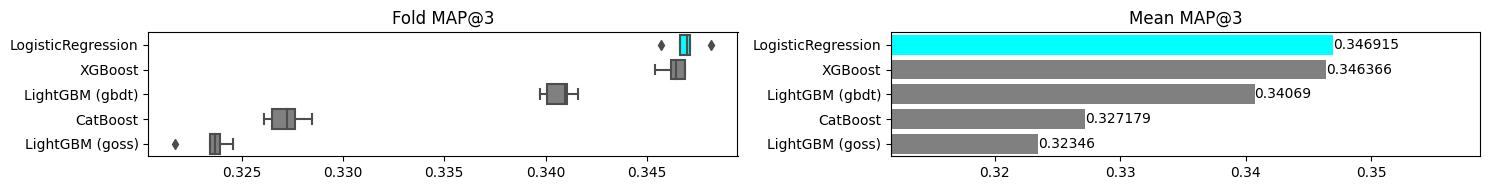

In [21]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()